## konlpy 설치
- 라이브러리 참고 : https://konlpy.org/ko/latest/index.html

In [28]:
!pip install konlpy

## 데이터 불러오기

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import pandas as pd
DATA_PATH = ('/content/drive/MyDrive/Colab Notebooks/data/text_mining/')

train_df = pd.read_csv(DATA_PATH + 'ratings_train.txt', sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [31]:
train_df['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [32]:
import re

train_df = train_df.fillna(' ')

# 정규 표현식 이용, 숫자를 공백으로 변경
train_df['document'] = train_df['document'].apply( lambda x : re.sub(r'\d+', " ", x))
train_df['document']

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 150000, dtype: object

In [33]:
# 테스트 데이터 셋을 로딩하고 동일하게 Null 및 숫자를 공백으로 변환

test_df = pd.read_csv(DATA_PATH + 'ratings_test.txt', sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply( lambda x : re.sub(r"\d+", " ", x) )

In [34]:
# id컬럼 삭제
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

## 워드 클라우드
- 참고 : https://amueller.github.io/word_cloud/auto_examples/index.html

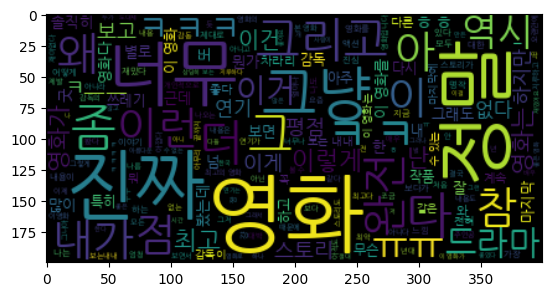

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

train_review = [review for review in train_df['document'] if type(review) is str]
wordcloud = WordCloud(font_path = DATA_PATH + 'NanumGothic.ttf').generate(' '.join(train_review))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [39]:
from konlpy.tag import Twitter

twiter = Twitter()
def tw_tokenizer(text):
    # 입력 인자로 들어온 text 를 형태소 단어로 토큰화 하여 list 객체 반환
    tokens_ko = twiter.morphs(text)
    return tokens_ko

/usr/local/lib/python3.10/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Twitter 객체의 morphs( ) 객체를 이용한 tokenizer를 사용. ngram_range는 (1,2)
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

In [41]:
# Logistic Regression 을 이용하여 감성 분석 Classification 수행.
lg_clf = LogisticRegression(random_state=0, solver='liblinear')

# Parameter C 최적화를 위해 GridSearchCV 를 이용.
params = { 'C': [1 ,3.5, 4.5, 5.5, 10 ] }
grid_cv = GridSearchCV(lg_clf , param_grid=params , cv=3 ,scoring='accuracy', verbose=1 )
grid_cv.fit(tfidf_matrix_train , train_df['label'] )
print(grid_cv.best_params_ , round(grid_cv.best_score_,4))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'C': 3.5} 0.8593
